# Training logs

Here we will observe the training and validation loss and metrics observed during the deep learning models training

## Imports

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

## Graphics parameters

In [2]:
plt.rcParams.update({"axes.facecolor": "white"})

First we define the root dir where models and logs are stored

In [3]:
dataset_dir = None

for dropbox_path in [r"C:\Users\flori\Dropbox (Partners HealthCare)", r"C:\Users\f.chabrun\Partners HealthCare Dropbox\Floris Chabrun"]:
    if os.path.exists(dropbox_path):
        print(f"Found DROPBOX folder")
        break

Found DROPBOX folder


## BiAge model

We will first load the model and logs for the BiAge model

In [4]:
model_dir = os.path.join(dropbox_path, r"Floris\SPECTR-MS\out\checkpoints", r"v92_age_v2\age_v2_base_batch_size_32")
model_path = os.path.join(dropbox_path, model_dir, "epoch=33-step=8466.ckpt")
logs_path = os.path.join(dropbox_path, model_dir, "logs/version_0/metrics.csv")

Then we will read epoch/step at which training was stopped by early stopping callback from the last checkpoint's file name

In [5]:
stop_epoch = int(re.sub(".+epoch=([0-9]+).+", "\\1", model_path))
stop_step = int(re.sub(".+step=([0-9]+).+", "\\1", model_path))
print(f"Last epoch was: {stop_epoch}")
print(f"Last step was: {stop_step}")

Last epoch was: 33
Last step was: 8466


We can then read logs

In [6]:
logs = pd.read_csv(logs_path)
logs

,loss,epoch,step,val_corcoef,val_loss
0,1.070417,0,99,NaN,NaN
1,1.067092,0,199,NaN,NaN
2,NaN,0,248,0.304127,0.978097
3,0.926681,1,299,NaN,NaN
4,1.080756,1,399,NaN,NaN
...,...,...,...,...,...
148,0.740554,42,10699,NaN,NaN
149,NaN,42,10706,0.545934,0.846361
150,0.940932,43,10799,NaN,NaN
151,0.817165,43,10899,NaN,NaN


For convenience, we will separate the dataset into training and validation logs

In [7]:
training_logs = logs[~pd.isna(logs.loss)][["epoch", "step", "loss"]]
val_logs = logs[~pd.isna(logs.val_loss)][["epoch", "step", "val_loss", "val_corcoef"]].rename(columns={"val_loss": "loss", "val_corcoef": "corcoef"})

In [8]:
training_logs

,epoch,step,loss
0,0,99,1.070417
1,0,199,1.067092
3,1,299,0.926681
4,1,399,1.080756
6,2,499,0.928367
...,...,...,...
146,42,10499,0.835848
147,42,10599,0.865781
148,42,10699,0.740554
150,43,10799,0.940932


In [9]:
val_logs

,epoch,step,loss,corcoef
2,0,248,0.978097,0.304127
5,1,497,1.012136,0.280083
9,2,746,1.305568,0.347585
12,3,995,0.962173,0.391099
16,4,1244,0.916862,0.424470
19,5,1493,0.957303,0.436574
23,6,1742,1.018333,0.455146
26,7,1991,0.991638,0.457334
30,8,2240,0.907583,0.487676
33,9,2489,0.876733,0.512770


To make figures clearer, we will compute the exponential moving average loss at each step, using a span=10

In [10]:
ema_span = 10

training_logs["loss_ema"] = training_logs.ewm(span=ema_span).mean()["loss"]
val_logs["loss_ema"] = val_logs.ewm(span=ema_span).mean()["loss"]
val_logs["corcoef_ema"] = val_logs.ewm(span=ema_span).mean()["corcoef"]

Finally, we can plot loss and correlation coefficient between BiAge and chronological age during training

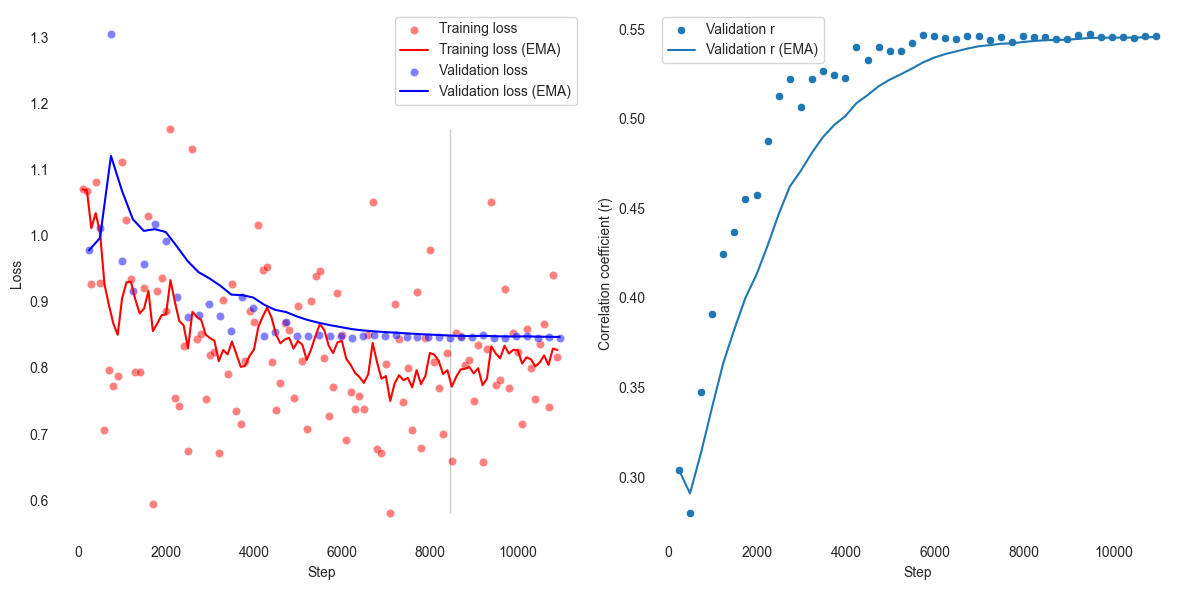

In [11]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)

# plot training error
# raw loss, as dots
ax = sns.scatterplot(data=training_logs, x="step", y="loss", alpha=.5, label="Training loss", color="red")  # as dots
# then ema smoothed, as lines
ax = sns.lineplot(data=training_logs, x="step", y="loss_ema", color="red", label="Training loss (EMA)", ax=ax)  # as lines

# plot validation error
# raw loss, as dots
ax = sns.scatterplot(data=val_logs, x="step", y="loss", alpha=.5, color="blue", label="Validation loss", ax=ax)  # as dots
# then ema smoothed, as lines
ax = sns.lineplot(data=val_logs, x="step", y="loss_ema", color="blue", label="Validation loss (EMA)", ax=ax)  # as lines

# draw a line where training was stopped due to early stopping
sns.lineplot(data=None, x=[stop_step, stop_step], y=[training_logs.loss.min(), training_logs.loss.max()], color="black", linewidth=10)

plt.xlabel("Step")
plt.ylabel("Loss")

plt.subplot(1, 2, 2)

# plot correlation coefficient (for val)
# raw loss, as dots
ax = sns.scatterplot(data=val_logs, x="step", y="corcoef", label="Validation r")  # as dots
# then ema smoothed, as lines
ax = sns.lineplot(data=val_logs, x="step", y="corcoef_ema", label="Validation r (EMA)", ax=ax)  # as lines

plt.xlabel("Step")
plt.ylabel("Correlation coefficient (r)")

plt.tight_layout()
plt.show()

## Race prediction model

We can repeat previous steps to assess the performance of the race prediction model during training

In [12]:
def load_logs_and_preprocess(model_subdir: str, model_last_ckpt_name: str, model_logs_subdir: str = "logs/version_0/metrics.csv") -> tuple:
    
    model_dir = os.path.join(dropbox_path, r"Floris\SPECTR-MS\out\checkpoints", model_subdir)
    model_path = os.path.join(dropbox_path, model_dir, model_last_ckpt_name)
    logs_path = os.path.join(dropbox_path, model_dir, model_logs_subdir)
    
    stop_epoch = int(re.sub(".+epoch=([0-9]+).+", "\\1", model_path))
    stop_step = int(re.sub(".+step=([0-9]+).+", "\\1", model_path))
    print(f"Last epoch was: {stop_epoch}")
    print(f"Last step was: {stop_step}")
    
    logs = pd.read_csv(logs_path)
    print(logs)
    
    training_logs = logs[~pd.isna(logs.loss)][["epoch", "step", "loss"]]
    val_logs = logs[~pd.isna(logs.val_loss)][["epoch", "step", "val_loss", "val_accuracy"]].rename(columns={"val_loss": "loss", "val_accuracy": "accuracy"})
    
    ema_span = 10
    
    training_logs["loss_ema"] = training_logs.ewm(span=ema_span).mean()["loss"]
    val_logs["loss_ema"] = val_logs.ewm(span=ema_span).mean()["loss"]
    val_logs["accuracy_ema"] = val_logs.ewm(span=ema_span).mean()["accuracy"]
    
    return training_logs, val_logs, stop_epoch, stop_step

def plot_training_val_metrics(training_logs, val_logs, stop_epoch, stop_step):
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    
    # plot training error
    # raw loss, as dots
    ax = sns.scatterplot(data=training_logs, x="step", y="loss", alpha=.5, label="Training loss", color="red")  # as dots
    # then ema smoothed, as lines
    ax = sns.lineplot(data=training_logs, x="step", y="loss_ema", color="red", label="Training loss (EMA)", ax=ax)  # as lines
    
    # plot validation error
    # raw loss, as dots
    ax = sns.scatterplot(data=val_logs, x="step", y="loss", alpha=.5, color="blue", label="Validation loss", ax=ax)  # as dots
    # then ema smoothed, as lines
    ax = sns.lineplot(data=val_logs, x="step", y="loss_ema", color="blue", label="Validation loss (EMA)", ax=ax)  # as lines
    
    # draw a line where training was stopped due to early stopping
    sns.lineplot(data=None, x=[stop_step, stop_step], y=[training_logs.loss.min(), training_logs.loss.max()], color="black", linewidth=10)
    
    plt.xlabel("Step")
    plt.ylabel("Loss")
    
    plt.subplot(1, 2, 2)
    
    # plot correlation coefficient (for val)
    # raw loss, as dots
    ax = sns.scatterplot(data=val_logs, x="step", y="accuracy", label="Validation accuracy (%)")  # as dots
    # then ema smoothed, as lines
    ax = sns.lineplot(data=val_logs, x="step", y="accuracy_ema", label="Validation accuracy (EMA)", ax=ax)  # as lines
    
    plt.xlabel("Step")
    plt.ylabel("Correlation coefficient (r)")
    
    plt.tight_layout()
    plt.show()

Last epoch was: 39
Last step was: 8400
         loss   step  epoch  val_accuracy_class_1  val_loss  \
0    0.615676     99      0                   NaN       NaN   
1    0.300789    199      0                   NaN       NaN   
2         NaN    209      0              0.225092  0.668113   
3    0.469849    299      1                   NaN       NaN   
4    0.487055    399      1                   NaN       NaN   
..        ...    ...    ...                   ...       ...   
150       NaN  10289     48              0.878229  0.248335   
151  0.167106  10299     49                   NaN       NaN   
152  0.241647  10399     49                   NaN       NaN   
153  0.257213  10499     49                   NaN       NaN   
154       NaN  10499     49              0.874539  0.244052   

     val_accuracy_class_0  val_accuracy  
0                     NaN           NaN  
1                     NaN           NaN  
2                0.976939      0.704545  
3                     NaN           

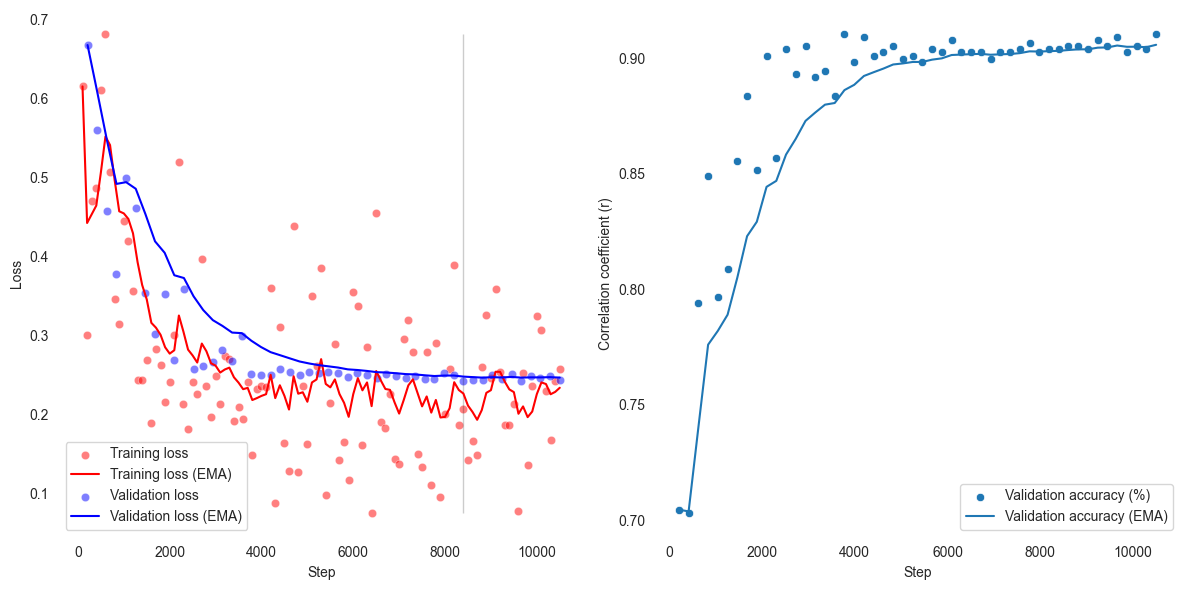

In [13]:
logs_data = load_logs_and_preprocess(model_subdir=r"v92_race_v2\v2_base_batch_size_32", model_last_ckpt_name="epoch=39-step=8400.ckpt")
plot_training_val_metrics(*logs_data)

## Sex prediction model

Last epoch was: 12
Last step was: 3172
    epoch  step      loss  val_accuracy  val_accuracy_class_1  \
0       0    99  0.606371           NaN                   NaN   
1       0   199  0.705335           NaN                   NaN   
2       0   243       NaN      0.628308              0.142857   
3       1   299  0.688437           NaN                   NaN   
4       1   399  0.541750           NaN                   NaN   
..    ...   ...       ...           ...                   ...   
74     21  5367       NaN      0.627158              0.425466   
75     22  5399  0.545358           NaN                   NaN   
76     22  5499  0.470380           NaN                   NaN   
77     22  5599  0.669805           NaN                   NaN   
78     22  5611       NaN      0.649022              0.214286   

    val_accuracy_class_0  val_loss  
0                    NaN       NaN  
1                    NaN       NaN  
2               0.914077  0.663350  
3                    NaN       N

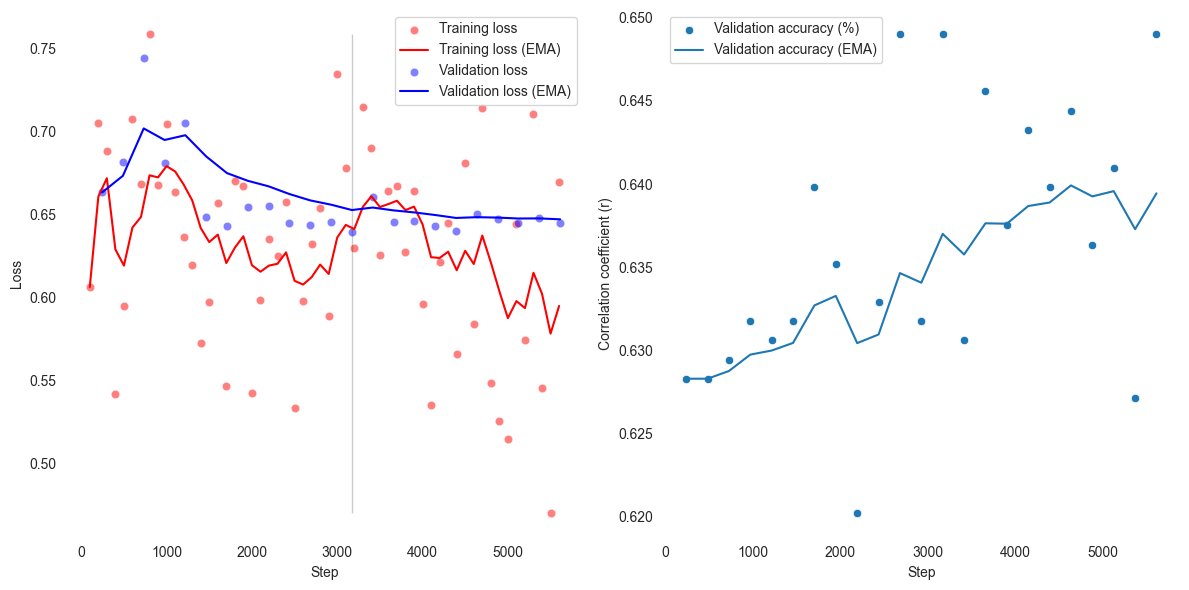

In [14]:
logs_data = load_logs_and_preprocess(model_subdir=r"v92_sex_v2\v2_base_batch_size_32", model_last_ckpt_name="epoch=12-step=3172.ckpt")
plot_training_val_metrics(*logs_data)